In [1]:
pip install -U https://github.com/PythonOT/POT/archive/master.zip # with --user for user install (no root)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/PythonOT/POT/archive/master.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sklearn.utils as utils
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import imageio
import os

In [3]:
import ot
import ot.plot

In [4]:
import brenier
import utils




*   $$\varphi_w^c(y_j)≈{\hat\varphi_w^c(y_j)}=\min_i \{c(x_i,y_j)- \varphi_w(x_i) \}$$

*   $$ loss = \max_w \{ \frac{1}{n}\sum_{i=1}^n\varphi_w(x_i) + \frac{1}{m}\sum_{j=1}^m\varphi_w^c(y_j)   \} $$

*   $$\underbrace{\varphi^{Brenier}}_{convex}= \frac{1}{2}\|x\|^2-\varphi_w^{Kantorovich}(x)$$

*   $$ T(x) = \nabla\varphi^{Brenier}(x)  $$



In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

In [6]:
def low_plot(source_train,target_train,result,ep):
  
  fig, ax = plt.subplots(figsize = [3,3])

  ax.set_xlim(-3,3)
  ax.set_ylim(-3,3)
  ax.set_title(f"epoch {ep}")
  ax.scatter(source_train[:,0],source_train[:,1])
  ax.scatter(target_train[:,0],target_train[:,1])
  ax.scatter(result[:,0],result[:,1])

  plt.savefig(f"epoch {ep}.png")

  plt.close()

def high_plot(result,ep):


  plt.figure(figsize=(15, 15))
  for i, comp in enumerate(result[0:50].cpu().detach().numpy()) :
      plt.subplot(10, 10, i + 1)
      plt.imshow(comp.reshape((28, 28)), cmap='gray',vmax=1,vmin=0)
      plt.axis('off')

  plt.suptitle(f"epoch {ep}",y=0.9,fontsize=16)
  plt.savefig(f"epoch {ep}.png",bbox_inches="tight")

  plt.close()

In [7]:
def noise_train(model_icnn,device, train_loader, optimizer, 
                epoch,noise_bool=True,print_bool=True, high_plot_bool = False,alpha=0):
    model = model_icnn.to(device)
    for ep in range(epoch):
      for data in train_loader:
          data = data.float().to(device)
          if noise_bool:
             temp_data = utils.data_noise(data,std=0.15,seed=ep)
             model.target = utils.data_noise(model.init_target)
          optimizer.zero_grad()

          loss = -model.dual(temp_data)
          loss.backward()
          optimizer.step()

          for l in range(len(model.convex_func.w_zs)):
            model.convex_func.w_zs[l].weight.data.copy_(torch.relu(model.convex_func.w_zs[l].weight.data))

      if high_plot_bool and ep%50==0:
          result =model.transport(torch.tensor(test_set1[:100]).float().to(device)).data.cpu()
          high_plot(result,ep)


      if ep%500==0 and print_bool:
          print(ep,model.dual(data).data)

    if high_plot_bool:
      with imageio.get_writer("sample_data/MNIST.gif", mode="I") as writer:
          for ep in range(epoch):
            if ep%50 == 0:
              image = imageio.imread(f"epoch {ep}.png")
              writer.append_data(image)
              os.remove(f"epoch {ep}.png")


In [8]:
from keras.datasets import fashion_mnist
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(-1,784)
x_test = x_test.reshape(-1,784)

x_train = x_train/255. #  rescale to (0,1)
x_test = x_test/255.  #  rescale to (0,1)


In [9]:
index_train = [np.where(y_train==i) for i in range(10)]
index_test = [np.where(y_test==i) for i in range(10)]

In [10]:
# 20% for training and 80% for testing

def split(x,seed=0):
  n = len(x)
  index = np.arange(n)
  n_train = int(0.8*n)
  
  np.random.seed(seed)
  np.random.shuffle(index)

  return x[:n_train],x[n_train:]

In [11]:
set1,test_set1 = split(x_train[index_train[8][0]][:100])   #(set1,test_set1) =  (trainning source,test_source) 
set2,test_set2 = split(x_train[index_train[3][0]][:100])   #(set2,test_set2) =  (trainning target,test_target) 

Add noise

In [12]:
Train_loader = torch.utils.data.DataLoader(set1,batch_size=len(set1))

icnn1 = brenier.ICNN(784)
model_icnn1 = brenier.c_transform(torch.tensor(set2).float().to(device),icnn1)
optimizer1 = torch.optim.Adam(model_icnn1.parameters(),0.0003,[0.95,0.95],1e-6)

In [13]:
noise_train(model_icnn1, device, Train_loader, optimizer1, 5001,high_plot_bool=False,alpha=0.)

0 tensor(-139.3553, device='cuda:0')
500 tensor(44.9021, device='cuda:0')
1000 tensor(44.9239, device='cuda:0')
1500 tensor(44.9055, device='cuda:0')
2000 tensor(44.7812, device='cuda:0')
2500 tensor(44.9521, device='cuda:0')
3000 tensor(44.9186, device='cuda:0')
3500 tensor(44.9155, device='cuda:0')
4000 tensor(44.9184, device='cuda:0')
4500 tensor(44.9292, device='cuda:0')
5000 tensor(44.9596, device='cuda:0')


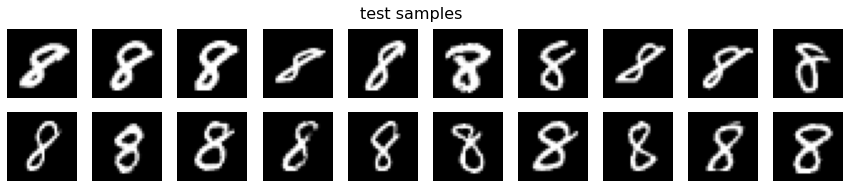

In [14]:
plt.figure(figsize=(15, 15))
for i, comp in enumerate(test_set1[:50]) :
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap='gray',vmax=1,vmin=0)
    plt.axis('off')
plt.suptitle('test samples',y=0.9,fontsize=16)
plt.savefig('test samples.pdf',bbox_inches="tight")

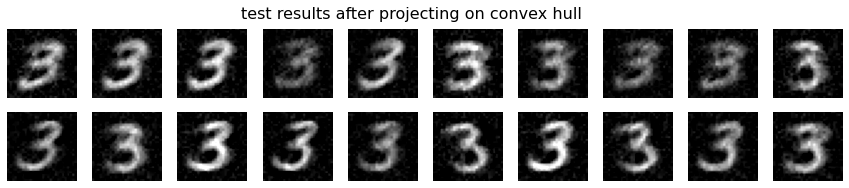

In [15]:
test_result =model_icnn1.transport(torch.tensor(test_set1).float().to(device)).data
fake_target = test_result.cpu().detach().numpy()

plt.figure(figsize=(15, 15))
for i, comp in enumerate(fake_target[:50]) :
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap='gray',vmax=1,vmin=0)
    plt.axis('off')
plt.suptitle('test results after projecting on convex hull',y=0.9,fontsize=16)
plt.savefig('test results.pdf',bbox_inches="tight")

In [16]:
from sklearn.decomposition import PCA
from sklearn import svm

def find_projection(source, target):

  A = np.concatenate([source.reshape(1,-1),target])
  L = np.ones(A.shape[0])
  L[0] = 0

  clf = svm.SVC(kernel="linear", C=100)
  clf.fit(A, L)

  if clf.score(A,L)==1. :
    w = clf.coef_[0]
    projection = clf.support_vectors_[0]+ 2/np.sum(w**2)*w
    return projection
  
  return source


In [17]:
c1_proj = fake_target.copy()[:50]
for i in range(len(c1_proj)):
  c1_proj[i] = find_projection(fake_target[i], set2)

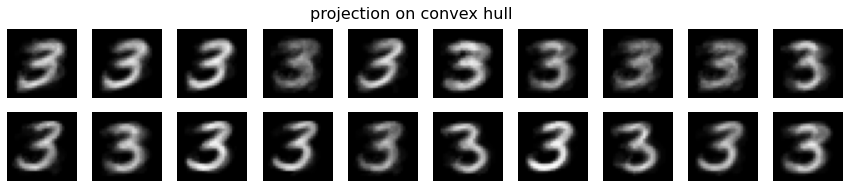

In [18]:
plt.figure(figsize=(15, 15))
for i, comp in enumerate(c1_proj[:50]) :
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap='gray',vmax=1,vmin=0)
    plt.axis('off')
plt.suptitle('projection on convex hull',y=0.9,fontsize=16)
plt.savefig('test results(on convex hull).pdf',bbox_inches="tight")